In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
import gc
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

### IMPORTACION DE DATASET

In [2]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
#contador = 0
#data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 3
#for l in parse('C:\\Users\\Usuario\\source\\repos\\steam_reviews.json.gz'):
#    if contador%n == 0:
#        data_reviews.append(l)
#    else:
 #         pass
 #         contador += 1
    
 


In [3]:
data_games = []
for l in parse('C:\\Users\\Usuario\\source\\repos\\steam_games.json.gz'):
        data_games.append(l)

In [5]:
#data_reviews = pd.DataFrame(data_reviews)
#data_reviews.drop('Unnamed: 0',axis=1,inplace=True)


In [6]:
#data_reviews.to_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews.csv')
#del data_reviews

In [5]:
data_reviews= pd.read_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews.csv')


In [6]:
data_reviews.drop('Unnamed: 0', axis=1,inplace=True)

In [4]:
data_games = pd.DataFrame(data_games)

### DESCRIPCIÓN DE FEATURES DATA_REVIEWS

**username:** Nombre del usuario que ha dejado la reseña

**hours:** Cantidad de horas jugadas (acumuladas) en el juego al cual se le ha hecho la reseña

**products:** Cantidad de otros juegos probados

**product_id:** Identificacion númerica del juego reseñado

**page_order:** Número de página en el cual se encuentra el juego dentro de la plataforma

**date:** Fecha en la cual se ha creado la reseña

**text:** Comentario sobre el juego

**early_access:** Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

**page:** No es interpretable

**user_id:** Identificacion númerica del usuario creador de la reseña

**found_funny:** Cantidad de calificaciones positivas creadas por otros usuarios

**compensation:** Variable no interpretable dada la cantidad de valores nulos contenidos en ella


In [7]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


### DESCRIPCIÓN DE FEATURES INCLUIDOS EN DATA_GAMES

**desarrollador:** Creador del juego

**genres:** Géneros, caracteristicas del juego

**app_name:** Editor del juego

**title:** Nombre del juego

**url:** Dirección web donde encontrarlo

**release_date:** Fecha de lanzamiento

**tags:** Etiquetas relacionadas con el juego

**discount_price:** Precio con descuento incluido

**reviews_url:** Dirección web donde encontrar las reseñas sobre el juego

**specs:** Especificaciones

**price:** Precio sin descuento

**early_access:** Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

**id:** Identificacion númerica del juego publicado

**sentiment:** Emoción promedio generada en los usuarios

**metascore:** Puntaje promedio recibido por los usuarios


### ANALISIS EXPLORATORIO DATA_REVIEWS

In [8]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,7.656120e+16


Cantidad de filas y columnas

In [9]:
data_reviews.shape

(7793069, 12)

Información del tipo de dato contenido en cada feature

In [10]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793069 entries, 0 to 7793068
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   username      object 
 1   hours         float64
 2   products      float64
 3   product_id    int64  
 4   page_order    int64  
 5   date          object 
 6   text          object 
 7   early_access  bool   
 8   page          int64  
 9   found_funny   float64
 10  compensation  object 
 11  user_id       float64
dtypes: bool(1), float64(4), int64(3), object(4)
memory usage: 661.5+ MB


Visualización de valores nulos contenidos en cada feature

In [12]:
data_reviews.isna().sum()

username            208
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text              17972
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

Estadisticos de las variables númericas que contribuyen a definir la calificación del usuario

In [11]:
data_reviews.loc[:,['hours','products']].describe().round(2)

,hours,products
count,7766532.00,7778108.00
mean,111.84,236.48
std,392.86,485.79
min,0.00,1.00
25%,4.00,45.00
50%,15.30,110.00
75%,59.70,246.00
max,42100.70,18188.00


De los estadisticos obtenidos podemos decir que la base de datos contiene valores que no deberían ser considerados dentro del análisis. Estos son los valores extremos como:

*Usuarios que han probado el juego por menos de 10 horas acumuladas (no tienen el expertise necesario como para que su review sea considerada)

*Usuarios que han probado menos de 20 juegos

*Usuarios que han destinado mas de 100 horas a un juego

*Usuarios que han probado mas de 300 juegos 

In [13]:
data_reviews2=data_reviews[(data_reviews.products>20) & (data_reviews.products<300)]
data_reviews2=data_reviews2[(data_reviews2.hours>10) & (data_reviews2.hours<100)]
del data_reviews

In [14]:
data_reviews2.shape

(2231863, 12)

In [15]:
data_reviews2.isna().sum()

username             70
hours                 0
products              0
product_id            0
page_order            0
date                  0
text               4462
early_access          0
page                  0
found_funny     1930329
compensation    2201368
user_id         1252417
dtype: int64

In [16]:
indices_vacios=data_reviews2[data_reviews2.username.isna()].index
indices_vacios

Int64Index([  53571,   96741,  109254,  183052,  183278,  315025,  388952,
             526859,  585920, 1056356, 1265221, 1289050, 1296109, 1321800,
            1442146, 1594921, 1662447, 1749124, 1826167, 1926598, 1972583,
            2550455, 2602005, 2672712, 2795698, 2826345, 2963381, 3008927,
            3069909, 3132685, 3132717, 3635616, 3689605, 3751220, 3751330,
            3775656, 4031389, 4032479, 4207936, 4263776, 4514493, 4805527,
            4873973, 4908449, 4913661, 5036211, 5103461, 5613932, 5686884,
            5839502, 5852441, 5913225, 6118408, 6142129, 6224486, 6224686,
            6264615, 6388567, 6567550, 6582504, 6582599, 6582667, 6743015,
            6979869, 6980071, 7063376, 7132887, 7133046, 7436788, 7450747],
           dtype='int64')

In [17]:
data_reviews2.drop(indices_vacios,inplace=True)

Filtro el dataset quitando aquellos features que considero no van a ser útiles para el modelo

In [18]:
text_vacio=data_reviews2[data_reviews2.text.isna()].index

In [19]:
data_reviews2.drop(text_vacio,inplace=True)

In [20]:
data_reviews2.reset_index(drop=True,inplace=True)

In [21]:
data_reviews3=data_reviews2.loc[:,['username','hours','products','product_id','text']]
data_reviews3.isna().sum()
del data_reviews2

Visualización de la distribución de la variable "hours"

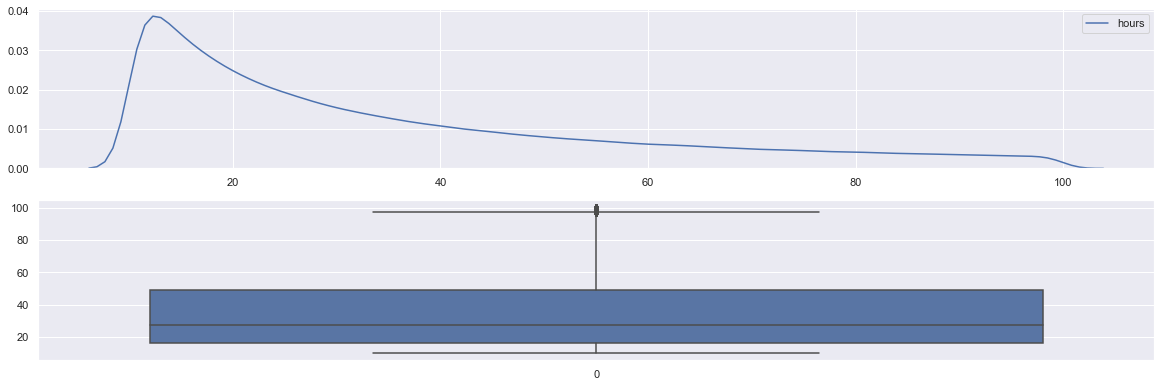

In [22]:

plt.figure(figsize=(20, 10))


plt.subplot(3,1,1)
sns.kdeplot(data=data_reviews3.hours)

plt.subplot(3,1,2)
sns.boxplot(data=data_reviews3.hours)

Visualización de la distribución de la variable "products"

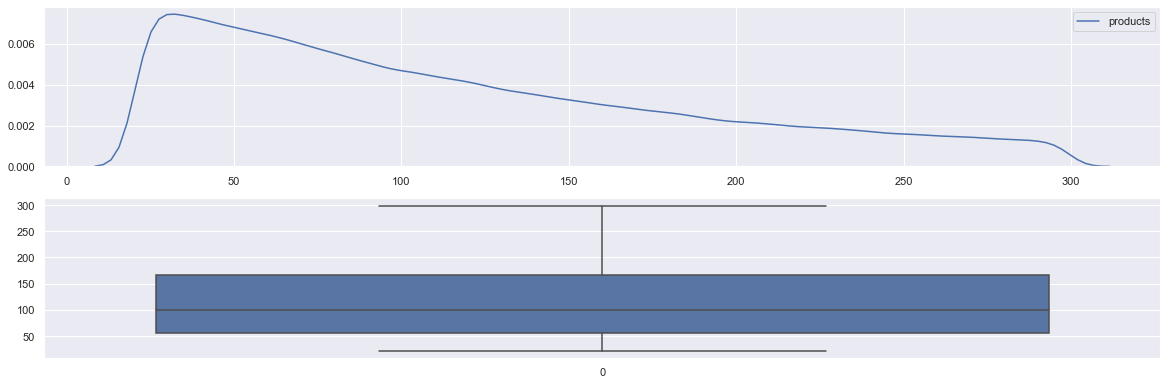

In [23]:
plt.figure(figsize=(20, 10))

plt.subplot(3,1,1)
sns.kdeplot(data=data_reviews3.products)

plt.subplot(3,1,2)
sns.boxplot(data=data_reviews3.products)

#### Algunas preguntas que respondemos 

1. Que cantidad de reviews deja en promedio cada usuario?

In [39]:
reviews_prom=data_reviews3.username.value_counts().mean()
print(f'El promedio de reviews por usuario es:{reviews_prom}')

El promedio de reviews por usuario es:2.173973006527782


2. Dentro de los limites establecidos, cual fue el usuario que mas reviews dejo y cual el que menos dejo?

In [87]:
print(f'El usuario que mas veces dejó un review fue:')
pd.DataFrame(data_reviews3.username.value_counts()).iloc[0]

El usuario que mas veces dejó un review fue:


username    553
Name: Alex, dtype: int64

In [88]:
print(f'Lo usuarios que dejaron unicamente un review son:')
min_rev=pd.DataFrame(data_reviews3.username.value_counts())==1
df_min=pd.DataFrame(data_reviews3.username.value_counts())[min_rev]
df_min.dropna()

Lo usuarios que dejaron unicamente un review son:


,username
Not_Kepci™ ^_^,1.0
Angeline,1.0
Azar_Stronghammer,1.0
Dancool Dan | trade.tf,1.0
finalkingom18,1.0
...,...
mintfresh,1.0
asta,1.0
Agent 47 CSGOEMPIRE.com,1.0
[DS] epictigerguy,1.0


3. Cual es el juego que mas reviews tuvo? cual el que menos reviews tuvo?

In [99]:
pd.DataFrame(data_reviews3.product_id.value_counts()).iloc[0]


product_id    30756
Name: 620, dtype: int64

Fin del analisis exploratorio. A continuación determino por medio de TextBlob, la polaridad de un review analizando la variable Text. 

Polaridad es un número décimal que oscila entre -1 y 1, donde 1 significa que el comentario transmite un sentimiento positivo y, -1 un sentimiento negativo

In [100]:
polarity_list=[]
for i in range(len(data_reviews3.text)):
    frase=TextBlob(data_reviews3.text[i])
    polarity=frase.sentiment.polarity
    polarity_list.append(polarity)

In [101]:
data_reviews3['Polarity']=pd.Series(polarity_list)

In [102]:
data_reviews3.to_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews4.csv')
del data_reviews3

In [103]:
data_reviews4= pd.read_csv('C:\\Users\\Usuario\\source\\repos\\data_reviews4.csv')

In [105]:
data_reviews4.head()

,Unnamed: 0,username,hours,products,product_id,text,Polarity
0,0,MR_SERENITY,14.8,147.0,35140,aweosme game great story and some epic moments...,0.375000
1,1,Duha Nubie,11.3,73.0,35140,first debut feel sweet,0.300000
2,2,The Undead StalkeR,17.0,87.0,35140,9/10\nEven after all these years. this game re...,0.471429
3,3,Mono,14.1,54.0,506510,A Charming game with colourful pixel graphics ...,0.300000
4,4,Uncle-Noob,24.7,37.0,350280,"I really like this game, but no one plays it. ...",-0.117532


In [112]:
data_reviews4.drop(['Unnamed: 0'], axis=1,inplace=True)

In [113]:
correlacion=data_reviews4.loc[:,['hours','products','Polarity']].corr()

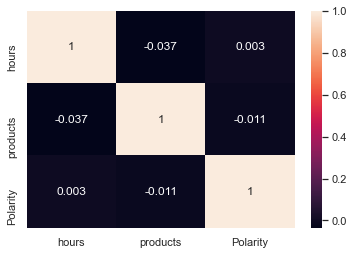

In [114]:
sns.heatmap(correlacion, cbar = True,annot = True)

Del mapa de calor se concluye que no existe ninguna relación directa entre un comentario positivo dejado por el usuario a un juego y la cantidad de horas jugadas, ni otros juegos probados. Esto nos permite afirmar que la relación es bivariable y por ende,no apreciable en el heatmap.

Con el fin de reafirmar lo concluido aquí, a continuación exponemos estadisticos y filtramos polaridad según dos criterios al mismo tiempo: horas y cantidad de juegos probados.

In [115]:
data_reviews4.loc[:,['hours','products','Polarity']].describe().round(2)

,hours,products,Polarity
count,2227331.00,2227331.00,2227331.00
mean,35.44,116.35,0.12
std,23.24,73.22,0.27
min,10.10,21.00,-1.00
25%,16.60,55.00,0.00
50%,27.60,99.00,0.10
75%,48.90,166.00,0.25
max,99.90,299.00,1.00


Criterio determinacion de Score: **Si la cantidad de productos está dentro de los valores del primer cuartil y la cantidad de horas jugadas es mayor al 75% de los valores de la muestra---> Calificación positiva (corroborado con el indice de polaridad)

**Si la cantidad de productos es mayor al 75% de los valores contenidos en la muestra y la cantidad de horas jugadas está dentro del primer 25% de los valores---> Calificación negativa (corroborado con el índice de polaridad)



In [116]:
positive_mask= (data_reviews4.hours>48) & (data_reviews4.products<55)

In [117]:
data_reviews4[positive_mask].Polarity.mean()

0.13175401820734617

El resultado obtenido es considerado suficiente para determinar como minimo de polaridad con la que un usuario calificaría como positivo al juego ya que, 0.13 es mayor al promedio de polaridad y, dado que la polaridad es un número que oscila entre -1 y 1 siendo -1 negativo y 1 positvo, el valor obtenido se encuentra mas cercano al extremo positivo que al extremo negativo

In [118]:
negative_mask=(data_reviews4.hours<16) & (data_reviews4.products>166)

In [119]:
data_reviews4[negative_mask].Polarity.mean()

0.11806886378669548

In [122]:
undefined_mask=(data_reviews4.Polarity<0.13117870234093953) & (data_reviews4.Polarity>0.0567740481140225)

In [125]:
data_reviews4[positive_mask]

,username,hours,products,product_id,text,Polarity
58,Mky,64.4,45.0,1840,It's a lot of fun if you know what you're doin...,0.521429
64,Kachigga,69.9,23.0,1840,Quite difficult to learn to use but after a co...,0.315556
79,SwaggerBallz,55.2,31.0,8880,I wish Steam would patch this game. I always e...,0.026667
93,Bricks04,73.9,32.0,1840,"Great tool, renders are crisp and resemble the...",0.224000
100,DatGuyT_T,94.5,46.0,1840,Very good best of all its free but REALLY need...,0.627500
...,...,...,...,...,...,...
2227165,Pobot,48.9,21.0,252490,this game is soo good.,0.150000
2227188,Cloud,65.2,50.0,252490,EPIC !,0.125000
2227218,Haetcher upgrader.gg,93.8,51.0,252490,The game is cool only it laagt extremely chopp...,-0.062500
2227253,]TDF[Gomer,91.4,43.0,252490,In the day and age were Dayz/Minecraft clones ...,0.071429


In [130]:
calif_pos=data_reviews4[positive_mask].shape[0]/data_reviews4.shape[0]
print(f'El {calif_pos*100}% de las reviews son positivas')

El 6.72549342688626% de las reviews son positivas


In [134]:
def conditions(data):
    if (data['Polarity'] > 0.13175401820734617):
        return 3
    elif (data['Polarity'] < 0.11806886378669548):
        return 1
    else:
        return 2

In [135]:
data_reviews4['Calif'] = data_reviews4.apply(conditions, axis=1)

In [136]:
data_reviews4.head()

,username,hours,products,product_id,text,Polarity,Calif
0,MR_SERENITY,14.8,147.0,35140,aweosme game great story and some epic moments...,0.375000,3
1,Duha Nubie,11.3,73.0,35140,first debut feel sweet,0.300000,3
2,The Undead StalkeR,17.0,87.0,35140,9/10\nEven after all these years. this game re...,0.471429,3
3,Mono,14.1,54.0,506510,A Charming game with colourful pixel graphics ...,0.300000,3
4,Uncle-Noob,24.7,37.0,350280,"I really like this game, but no one plays it. ...",-0.117532,1


### ANALISIS EXPLORATORIO DATA_GAMES

In [180]:
data_games2=data_games.loc[:,['id','title']]

In [181]:
data_games2

,id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,NaN
...,...,...
32130,773640,Colony On Mars
32131,733530,LOGistICAL: South Africa
32132,610660,Russian Roads
32133,658870,EXIT 2 - Directions


In [182]:
data_games2[data_games2.id.isna()]

,id,title
74,NaN,NaN
30961,NaN,Batman: Arkham City - Game of the Year Edition


In [183]:
#data_games2.title.fillna('buscar_valor',inplace=True)

In [184]:
#data_games2.id.fillna(0000,inplace=True)

In [185]:
data_games2.id=pd.to_numeric(data_games2.id,downcast='integer')

In [186]:
#data_reviews2[data_reviews2.product_id==764110]

### SISTEMA DE RECOMENDACION

In [187]:
reader=Reader()

In [188]:
data=Dataset.load_from_df(data_reviews4[['username','product_id','Calif']],reader=reader)

In [189]:
trainset,testset=train_test_split(data,test_size=.3)

In [190]:
algo=SVD()

In [191]:
algo.fit(trainset)

In [192]:
prediction=algo.test(testset)

In [193]:
usuario='Alex'

In [194]:
data_reviews_ok=data_reviews4.loc[:,['username','Calif','product_id']]

In [197]:
no_vista_usuario=data_reviews_ok[data_reviews_ok["username"]!=usuario]
no_vista_usuario.reset_index(drop=True,inplace=True)
no_vista_usuario=no_vista_usuario['product_id']

In [198]:
no_vista_usuario=pd.merge(left=pd.DataFrame(no_vista_usuario),right=data_games2, left_on='product_id', right_on='id')
no_vista_usuario.drop(['id'],inplace=True,axis=1)
no_vista_usuario.drop_duplicates(inplace=True)

In [204]:
no_vista_usuario.reset_index(drop=True,inplace=True)

In [205]:
no_vista_usuario['Score_model']=no_vista_usuario['product_id'].apply(lambda x: algo.predict(usuario,x).est)

In [207]:
no_vista_usuario['Username']=usuario

In [208]:
no_vista_usuario

,product_id,title,Score_model,Username
0,35140,Batman: Arkham Asylum Game of the Year Edition,2.198650,Alex
1,506510,Shadows of Adam,1.856275,Alex
2,350280,LawBreakers,1.591307,Alex
3,620900,Witchinour,2.206852,Alex
4,431320,Recourse Demo,1.869339,Alex
...,...,...,...,...
9653,673760,Air Tactical,1.539993,Alex
9654,460340,Guards,1.702710,Alex
9655,34420,XIII Century – Gold Edition,1.698583,Alex
9656,546380,Crispy Chicken,1.806299,Alex


In [209]:
accuracy.rmse(prediction)

RMSE: 0.9270


0.9270185435273325

In [ ]:
rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9013  0.9011  0.9017  0.9014  0.0002  
Fit time          117.51  115.93  59.54   97.66   26.96   
Test time         33.32   15.09   14.58   21.00   8.72    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9010  0.9010  0.9010  0.9010  0.0000  
Fit time          59.75   60.47   61.50   60.57   0.72    
Test time         10.70   14.52   11.05   12.09   1.72    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9000  0.8999  0.9000  0.9000  0.0001  
Fit time          63.43   64.82   65.19   64.48   0.76    
Test time         14.41   14.97   14.69   14.69   0.23    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

In [ ]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)


In [ ]:
gs.fit(data)

In [ ]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

In [67]:
#-----------------------------------------------------------------------------------------------#

In [68]:
n_usuarios=len(data_rev.reset_index(drop=True).iloc[0:1000])
n_items=len(data_games.id)
usuarios=data_rev.iloc[0:1000].username
items=data_games.id

NameError: name 'data_rev' is not defined

In [ ]:
user=data_reviews_ok.username.value_counts()[data_reviews_ok.username.value_counts()>3].index
items=title_id.id.unique()
n_user=len(user)
n_items=len(items)

In [ ]:
matriz_utilidad=pd.DataFrame(np.zeros((n_user,n_items)), index=user, columns=items).astype(pd.SparseDtype('float'))
matriz_utilidad

In [ ]:
for column in matriz_utilidad:
    spdtypes=matriz_utilidad.dtypes[column]
    
    matriz_utilidad[column] = matriz_utilidad[column].sparse.to_dense()
    
    
    mask_calif_columns=items==column
    calificaciones_column=data_reviews_ok.username.value_counts()[data_reviews_ok.username.value_counts()>3]
    
    
    matriz_utilidad[column].loc[calificaciones_column.index]=calificaciones_column
    

In [ ]:
items

In [ ]:
data_reviews_ok[data_reviews_ok.username.value_counts()>3]